# Modelos de regresión lineal

![BLR](https://upload.wikimedia.org/wikipedia/commons/e/ed/Bayes_icon.svg)

Hasta ahora hemos visto modelos de regresión lineal, usando inferencia exacta para la estimación de la distribución posterior de los parámetros, bajo un caso particular (suponiendo la varianza de la dispersión conocida). Si quisiéramos asumir previas distintas a la normal para los parámetros, incluyendo una previa para el parámetro de varianza, entonces la inferencia exacta de la distribución posterior se vuelve prácticamente imposible.

En este tema, estudiamos el uso de muestreo de la distribución posterior usando técnicas Montecarlo, dándonos la libertad de elegir la previa que mejor represente nuestro conocimiento de la situación.

> **Objetivos:**
> - Adoptar un lenguaje estándar para definir modelos probabilísticos.
> - Revisitar el modelo Gaussiano.
> - Revisitar modelos de predicción lineal desde una perspectiva de Montecarlo.

> **Referencias:**
> 
> - Statistical Rethinking: A Bayesian Course with Examples in R and Stan (2nd edition) - Richard McElreath.

## 1. Un lenguaje para escribir modelos probabilísticos.

Lo primero, es aprender el lenguaje con el que se describen comúnmente los modelos probabilísticos. Este tipo de descripciones son bastante estándar en casi todos los artículos académicos y libros en general, tanto en modelamiento Bayesiano y no Bayesiano, por lo que entender este lenguaje nos será de mucha utilidad.

A alto nivel, la receta es la siguiente:

1. Compilamos el conjunto de variables con el que vamos a trabajar. Algunas de estas variables son observables (las llamamos **datos**). Otras, no son observables, como tasas, medias, varianzas, entre otros... (las llamamos **parámetros**).
2. Definimos cada variable en términos de otras, o bien en términos de una distribución de probabilidad.
3. La combinación de las variables y sus distribuciones de probabilidad definen un **modelo generativo**, el cual puede usarse para simular observaciones hipotéticas o analizar observaciones reales.

Esta receta aplica en cada campo, desde ingeniería, hasta antropología. Normalmente, las dificultades radican en el área de estudio: ¿Cuáles variables son importantes y cómo las conectamos?

Una vez se tenga esto claro, escribir el modelo es más o menos simple.

**Ejemplo.** Consideremos, nuevamente, el caso de una moneda que tiramos $N$ veces. Queremos razonar acerca de las veces que la moneda cayó cara. 

Llamemos a la variable aleatoria del número de veces que la moneda cae cara $C$. Entonces:

\begin{align}
\begin{array}{lcl}
C & \sim & \text{Binomial}(N, p) \\
p & \sim & \text{Uniform}(0, 1)
\end{array}
\end{align}

En este ejemplo, $p$ es la probabilidad de que la moneda caiga cara en un solo tiro.

La anterior descripción del modelo puede leerse como:
> La cantidad de veces que la moneda cae cara $C$, distribuye binomial con tamaño de muestra $N$ y probabilidad $p$. La previa para $p$ se supone uniforme entre cero y uno.

Al escribir el modelo de esta forma, involucramos todas las suposiciones. Por ejemplo, en la distribución binomial sabemos que cada tiro es independiente de otros, de forma que estamos modelando los datos como muestras iid.

Una de las ventajas que comenzaremos a ver de ahora en adelante, es que en este **lenguaje probabilístico** nos distanciamos de las engorrosas formas matemáticas de las funciones de densidad, lo cual no significa que no las debamos tener presentes. Sin embargo, si es útil tener un lenguaje en el que resumamos todo el comportamiento, sin tener que estar escribiendo *tantas matemáticas*.

En un modelo como el de arriba, la primera línea define la función de verosimilitud usada en el teorema de Bayes, mientras que las demás definen las previas.

En el ejemplo, ambas relaciones son **estocásticas**, lo cual es indicado por el símbolo $\sim$. Una relación estocástica es simplemente una relación de un parámetro a una distribución. Luego escribiremos modelos con relaciones **deterministas** dentro de ellos. Vamos a denotar relaciones deterministass por el símbolo $=$.

## 2. Modelo Gaussiano de la altura.

Ya que conocemos las bases de la escritura de modelos probabilísticos, construyamos un modelo nosotros mismos.

Primero, modelaremos una variable como una distribución Gaussiana, la cual sabemos que tiene dos parámetros, la media $\mu$ y la varianza $\sigma^2$.

La actualización Bayesiana, nos permitirá considerar cada combinación posible de $\mu$ y $\sigma$, y las ponderará de acuerdo a su plausibilidad de acuerdo a los datos, dando lugar a la distribución posterior de $\mu$ y $\sigma$.

Los datos que modelaremos corresponden a un censo parcial de la población [!Kung San en el área Dobe (sur de África)](https://laulima.hawaii.edu/access/content/user/millerg/ANTH_200/A200Unit1/DobeKung.html). Los !Kung San son la población nómada más famosa del siglo 20, y la más estudiada también.

In [1]:
# Importar pandas
import pandas as pd

In [2]:
# Leer datos
height_data = pd.read_csv(
    "data/Howell1.csv",
    sep=";"
)
height_data.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


In [3]:
# Método describe
height_data.describe()

,height,weight,age,male
count,544.000000,544.000000,544.000000,544.000000
mean,138.263596,35.610618,29.344393,0.472426
std,27.602448,14.719178,20.746888,0.499699
min,53.975000,4.252425,0.000000,0.000000
25%,125.095000,22.007717,12.000000,0.000000
50%,148.590000,40.057844,27.000000,0.000000
75%,157.480000,47.209005,43.000000,1.000000
max,179.070000,62.992589,88.000000,1.000000


Observamos que hay mucha variabilidad en los datos correspondientes a la altura. En parte, esto viene dado porque hay información de personas de todas las edades. Por ahora, nos concentraremos en la población adulta:

In [4]:
# Extraer datos de adultos
adult_height_data = height_data[height_data["age"] >= 18]

In [5]:
# Método describe
adult_height_data.describe()

,height,weight,age,male
count,352.000000,352.000000,352.000000,352.000000
mean,154.597093,44.990486,41.138494,0.468750
std,7.742332,6.456708,15.967855,0.499733
min,136.525000,31.071052,18.000000,0.000000
25%,148.590000,40.256290,28.000000,0.000000
50%,154.305000,44.792210,39.000000,0.000000
75%,160.655000,49.292693,51.000000,1.000000
max,179.070000,62.992589,88.000000,1.000000


Para comenzar nuestro modelo, queremos modelar la altura de cada individuo como una distribución normal con media $\mu$, y desviación estándar $\sigma$:

$$
h_i \sim \text{Normal}(\mu, \sigma).
$$

> Ya no lo escribimos pero la suposición de iid va implícita en esta proposición.

Como antes, esta definición define la función de verosimilitud. Para completar los ingredientes en la regla de Bayes, necesitamos la previa para nuestros parámetros $\mu$ y $\sigma$, $P(\mu, \sigma)$. Comúnmente, las previas se especifican de manera independiente para cada parámetro, lo que implica la suposición de $P(\mu, \sigma)=P(\mu)P(\sigma)$. Con esto, escribimos:

$$
\begin{align}
\begin{array}{lcl}
h_i & \sim & \text{Normal}(\mu, \sigma) \\
\mu & \sim & \text{Normal}(170, 20) \\
\sigma & \sim & \text{Uniform}(0, 50)
\end{array}
\end{align}
$$

**¿Qué significan estas previas?**


La previa para $\mu$ es una previa Gaussiana algo *amplia*, centrada en $170$ cm y con el $95$% de probabilidad concentrada en el intervalo $170 \pm 40$ cm.

In [6]:
# Importamos scipy.stats norm y uniform
from scipy.stats import norm, uniform
# Pyplot
from matplotlib import pyplot as plt
# Numpy
import numpy as np

/home/esteban/anaconda3/envs/stat-rethink2-pymc_v4/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [7]:
# Previa para mu
prior_mu = norm(loc=170, scale=20)

Esto significa que el modelo asume que la **altura promedio** está, con alta probabilidad, entre $130$ cm y $210$ cm.

Ahora, la previa para $\sigma$ es plana; una distribución uniforme. Esta distribución restringe a $\sigma$ a estar entre cero, y $50$ con igual probabilidad:

In [8]:
# Previa para sigma
prior_sigma = uniform(loc=0, scale=50)

La desviación estándar obviamente debe de ser positiva, por lo que hace sentido que la cota inferior de la uniforme sea cero. 

¿Qué significa que esté acotada en $50$ cm por arriba? Significa que las alturas individuales se encontrarán en un rango de $100$ cm alrededor de la altura promedio.

Algo bastante importante, es que las previas hagan sentido, para lo cual una simulación **predictiva previa** es esencial.

In [10]:
# Librería Arviz: Análisis exploratorio de modelos Bayesianos
import arviz as az

In [9]:
# Simulación previa predictiva -- az.plot_kde
N = 1000
samples_mu = prior_mu.rvs(size=N)  # Muestreo de la previa de mu
samples_sigma = prior_sigma.rvs(size=N)  # Muestreo de la previa de sigma
samples_height = norm.rvs(loc=samples_mu, scale=samples_sigma)  # Muestreo de la verosimilitud

In [11]:
samples_height.shape

(1000,)

<Axes: >

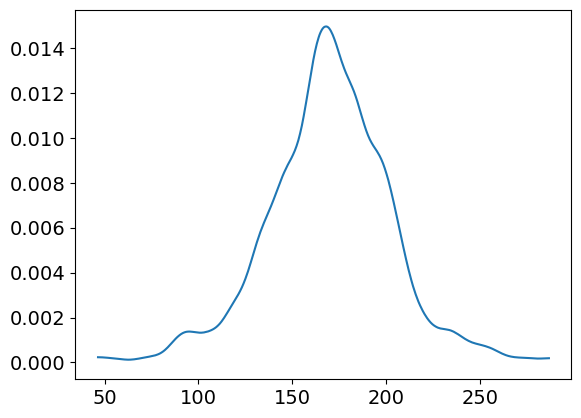

In [12]:
az.plot_kde(samples_height, bw=5)

Notemos que la distribución previa para la altura no es una Gaussiana. Esto es correcto. Es una distribución de las probabilidades de las diferentes alturas antes de ver los datos.

La simulación predictiva previa es una herramienta poderosa para darnos cuenta que tan buenas son nuestras previas. A través de ella, nos podríamos dar cuenta que, por ejemplo, una previa $\mu \sim \text{Normal}(170, 100)$, no sería adecuada:

In [15]:
prior_mu = norm(loc=170, scale=100)

In [16]:
# Simulación previa predictiva
N = 1000
samples_mu = prior_mu.rvs(size=N)  # Muestreo de la previa de mu
samples_sigma = prior_sigma.rvs(size=N)  # Muestreo de la previa de sigma
samples_height = norm.rvs(loc=samples_mu, scale=samples_sigma)  # Muestreo de la verosimilitud

<Axes: >

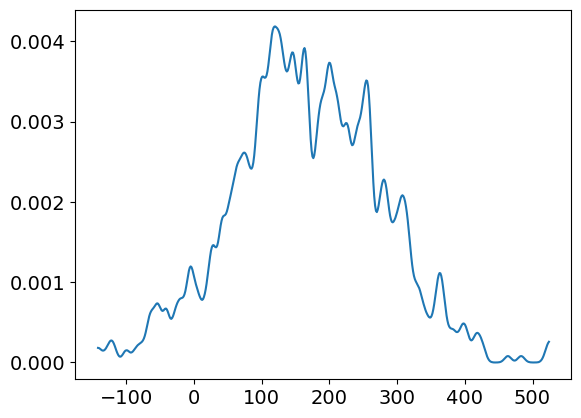

In [17]:
az.plot_kde(samples_height, bw=5)

In [18]:
(samples_height < 0).mean()

0.067

Con esta previa, estamos diciendo que el modelo antes de ver los datos, espera que $\sim 5$% de la población tenga una altura *negativa*.

¿Esto importa? Bueno, si tenemos una gran cantidad de datos, **NO**. Pero este no siempre será el caso. De cualquier forma, siempre convendrá tener previas que representen nuestro conocimiento lo mejor posible.

Nos quedaremos con nuestras previas originales.

**¿Cómo usamos la simulación Montecarlo para estimar las distribuciones posteriores?**

En el módulo pasado vimos que la simulación Montecarlo es una manera bastante efectiva de estimar distribuciones de probabilidad. 

La librería [pymc](https://www.pymc.io/welcome.html) automatiza la estimación de la distribución posterior haciendo uso de métodos MCMC, y con una sintaxis de python bastante sencilla, como veremos a continuación.

Recordamos el modelo:

$$
\begin{align}
\begin{array}{lcl}
h_i & \sim & \text{Normal}(\mu, \sigma) \\
\mu & \sim & \text{Normal}(170, 20) \\
\sigma & \sim & \text{Uniform}(0, 50)
\end{array}
\end{align}
$$

In [19]:
# Importamos pymc
import pymc as pm

In [25]:
# Definimos el modelo
with pm.Model() as height_model:
    mu = pm.Normal(
        name="mu",
        mu=170,
        sigma=20
    )
    sigma = pm.Uniform(
        name="sigma",
        lower=0,
        upper=50
    )
    height = pm.Normal(
        name="height",
        mu=mu,
        sigma=sigma,
        observed=adult_height_data["height"]
    )

Hasta acá solo hemos definido el modelo. Si queremos muestrear la distribución posterior usando MCMC:

In [29]:
pm.sample?

Signature:
pm.sample(
    draws: int = 1000,
    step=None,
    init: str = 'auto',
    n_init: int = 200000,
    initvals: Union[Dict[Union[aesara.graph.basic.Variable, str], Union[numpy.ndarray, aesara.graph.basic.Variable, str]], Sequence[Optional[Dict[Union[aesara.graph.basic.Variable, str], Union[numpy.ndarray, aesara.graph.basic.Variable, str]]]], NoneType] = None,
    trace: Union[pymc.backends.base.BaseTrace, List[str], NoneType] = None,
    chains: Optional[int] = None,
    cores: Optional[int] = None,
    tune: int = 1000,
    progressbar: bool = True,
    model=None,
    random_seed: Union[int, Sequence[int], numpy.ndarray, NoneType, numpy.random.mtrand.RandomState, numpy.random._generator.Generator] = None,
    discard_tuned_samples: bool = True,
    compute_convergence_checks: bool = True,
    callback=None,
    jitter_max_retries: int = 10,
    *,
    return_inferencedata: bool = True,
    keep_warning_stat: bool = False,
    idata_kwargs: dict = None,
    mp_ctx=None,
  

In [26]:
# Muestreamos
with height_model:
    height_idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Veamos lo que contiene el objeto `idata` (inference data):

In [27]:
# Objeto idata
height_idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

En el objeto `idata` está toda la información. Para visualizar gráficos de las distribuciones posteriores muestreadas, podemos hacer:

array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

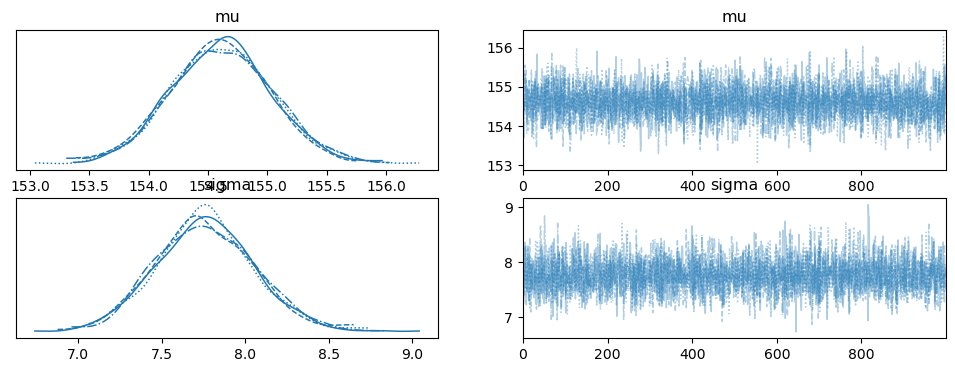

In [28]:
# az.plot_trace
az.plot_trace(height_idata)

O si lo queremos ver de forma numérica:

In [35]:
# az.summary
az.summary(
    height_idata,
    kind="stats",
    hdi_prob=0.89
)

,mean,sd,hdi_5.5%,hdi_94.5%
mu,154.610,0.423,153.947,155.284
sigma,7.763,0.294,7.276,8.213


**Interpretación de las distribuciones posteriores de los parámetros**

## 3. Predicción lineal

Lo que acabamos de ver es un modelo Gaussiano para la altura de una población de adultos. Sin embargo, este modelo no tiene el componente de *regresión*.

Es común que queramos modelar como el resultado de cierta variable se relaciona con otra(s) variable(s), llamada(s) **predictor(es)**. Si el predictor tiene alguna asociación estadística con la variable de interés, la podemos usar para *predecir* dicha variable.

En este caso estudiaremos como incluir estos predictores de forma lineal en el modelo. 

Seguiremos usando los datos de los adultos en la población, pero esta vez, veremos como la altura se relaciona con el peso:

In [36]:
adult_height_data.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


<Axes: xlabel='weight', ylabel='height'>

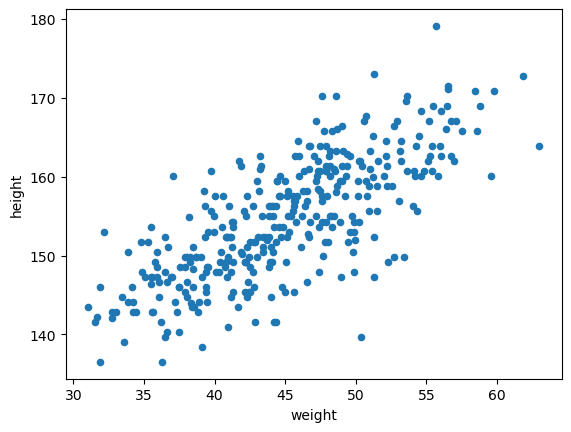

In [38]:
# Scatter plot
adult_height_data.plot.scatter(x="weight", y="height")

Del gráfico anterior, observamos que en definitiva hay una relación marcada entre la altura y el peso. Es decir, conocer el peso de una persona nos ayuda a predecir su altura.

**¿Cómo adecuamos el modelo de la altura para incluir el peso como predictor?**

La estrategia es modificar el parámetro $\mu$ de la distribución Gaussiana, para que sea una función lineal del predictor. Ahora, para los parámetros de esta función, tendremos que declarar distribuciones previas.

De forma que, teníamos:

$$
\begin{align}
\begin{array}{lcl}
h_i & \sim & \text{Normal}(\mu, \sigma) \\
\mu & \sim & \text{Normal}(170, 20) \\
\sigma & \sim & \text{Uniform}(0, 50)
\end{array}
\end{align}
$$

Ahora, sea $w_i$ el peso de la persona $i$ y sean $\bar{w}$ el promedio de todos los pesos. De esta forma:

$$
\begin{align}
\begin{array}{lcl}
h_i & \sim & \text{Normal}(\mu_i, \sigma) \\
\mu_i & = & \alpha + \beta(w_i - \bar{w}) \\
\alpha & \sim & \text{Normal}(170, 20) \\
\beta & \sim & \text{Normal}(0, 10) \\
\sigma & \sim & \text{Uniform}(0, 50)
\end{array}
\end{align}
$$

*¿Qué significa esto?*

- Como antes, la primera expresión es la verosimilitud (probabilidad de los datos). Es casi la misma expresión, nada más notemos que cambiamos la media general $\mu$, por una media $\mu_i$ para cada observación. Es decir, la media depende de los valores específicos de cada observación.

- La segunda expresión, corresponde al modelo lineal. $\mu$ ya no es un parámetro que estimemos, sino una relación determinista (notar el símbolo $=$ en lugar de $\sim$) a los nuevos parámetros $\alpha$ y $\beta$, y que depende de la variable observada $w_i$.

  ¿Porqué incluir como predictor $w_i - \bar{w}$ en lugar de símplemente $w_i$? Algo importante cuando modelamos es poder entender los parámetros que estamos introduciendo. Notemos que de la manera en que especificamos el modelo $\mu=\alpha$ cuando $w_i=\bar{w}$; es decir, $\alpha$ es el valor esperado de la altura cuando el peso es promedio.

  ¿Y qué pasa con $\beta$? Bueno, pues el parámetro $\beta$ es el cambio esperado en la altura, cuando el peso cambia $1$ unidad (kg).

- Las demás expresiones, como antes, son las previas de nuestros parámetros, que deberemos ajustar con una debida simulación predictiva previa de ser necesario.

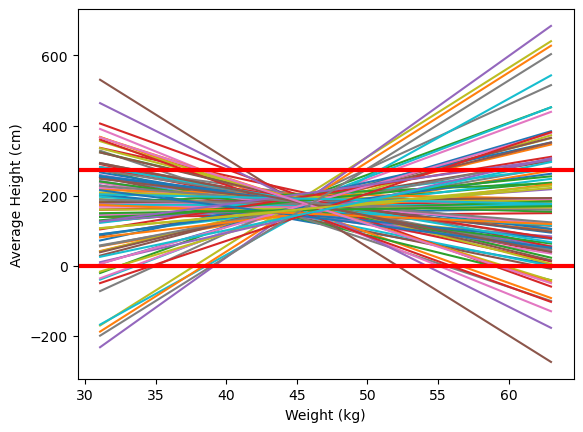

In [39]:
# Simulación previa predictiva
N = 100
w = np.linspace(
    adult_height_data["weight"].min(),
    adult_height_data["weight"].max()
)
w_bar = adult_height_data["weight"].mean()
sample_a = norm.rvs(loc=170, scale=20, size=N)
sample_b = norm.rvs(loc=0, scale=10, size=N)
sample_mu = sample_a + sample_b * (w - w_bar).reshape(-1, 1)
plt.plot(w, sample_mu)
plt.axhline(y=0, color="r", linewidth=3)
plt.axhline(y=272, color="r", linewidth=3)
plt.xlabel("Weight (kg)")
plt.ylabel("Average Height (cm)")
plt.show()

Observamos que usando estas previas, las la altura promedio puede llegar a tomar valores bastante extremos para valores normales del peso. Podemos hacer algo mejor.

De la gráfica de puntos, observamos que la relación entre la altura y el peso es positiva. Una manera común de restringir un parámetro a que sea positivo es usando la distribución $\text{Log-Normal}$. Si definimos $\beta$ como $\text{Log-Normal}(0, 1)$, significa que el logaritmo de $\beta$ tiene una distribución $\text{Normal}(0, 1)$:

$$
\beta \sim \text{Log-Normal}(0, 1)
$$

In [40]:
# Importamos lognorm de scipy.stats
from scipy.stats import lognorm

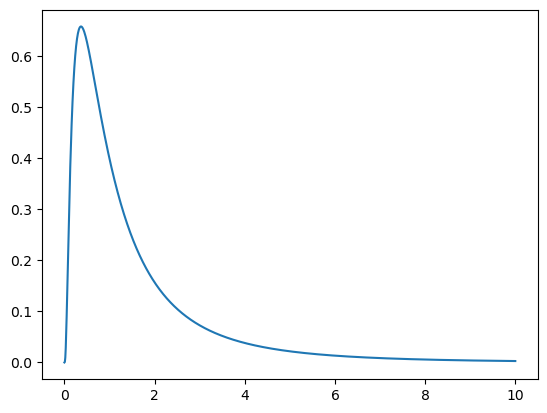

In [44]:
# Densidad lognormal
x = np.linspace(0, 10, 1000)
plt.plot(x, lognorm.pdf(x, loc=0, s=1))

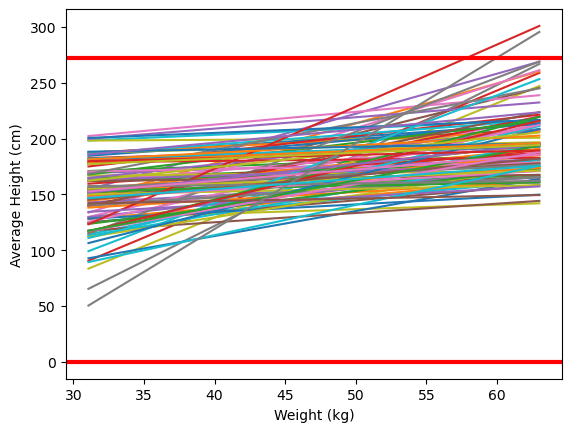

In [45]:
# Simulación previa predictiva
N = 100
w = np.linspace(
    adult_height_data["weight"].min(),
    adult_height_data["weight"].max()
)
w_bar = adult_height_data["weight"].mean()
sample_a = norm.rvs(loc=170, scale=20, size=N)
sample_b = lognorm.rvs(loc=0, s=1, size=N)
sample_mu = sample_a + sample_b * (w - w_bar).reshape(-1, 1)
plt.plot(w, sample_mu)
plt.axhline(y=0, color="r", linewidth=3)
plt.axhline(y=272, color="r", linewidth=3)
plt.xlabel("Weight (kg)")
plt.ylabel("Average Height (cm)")
plt.show()

¡Esto se ve mucho mejor!

De forma que nuestro modelo completo es:

$$
\begin{align}
\begin{array}{lcl}
h_i & \sim & \text{Normal}(\mu_i, \sigma) \\
\mu_i & = & \alpha + \beta(w_i - \bar{w}) \\
\alpha & \sim & \text{Normal}(170, 20) \\
\beta & \sim & \text{Log-Normal}(0, 1) \\
\sigma & \sim & \text{Uniform}(0, 50)
\end{array}
\end{align}
$$

**Estimemos la distribución posterior usando MCMC:**

In [47]:
weight = adult_height_data["weight"]
w_bar = weight.mean()
with pm.Model() as height_model_predictive:
    sigma = pm.Uniform("sigma", 0, 50)

    a = pm.Normal("a", 170, 20)
    b = pm.LogNormal("b", 0, 1)

    mu = a + b * (weight - w_bar)

    height = pm.Normal("height", mu, sigma, observed=adult_height_data["height"])

    height_pred_idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, a, b]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [48]:
# Distribución posterior de los parámetros
az.summary(
    height_pred_idata,
    kind="stats",
    hdi_prob=0.89
)

,mean,sd,hdi_5.5%,hdi_94.5%
a,154.607,0.272,154.181,155.047
sigma,5.103,0.196,4.777,5.397
b,0.904,0.042,0.833,0.968


array([[<Axes: title={'center': 'a'}>, <Axes: title={'center': 'a'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'b'}>, <Axes: title={'center': 'b'}>]],
      dtype=object)

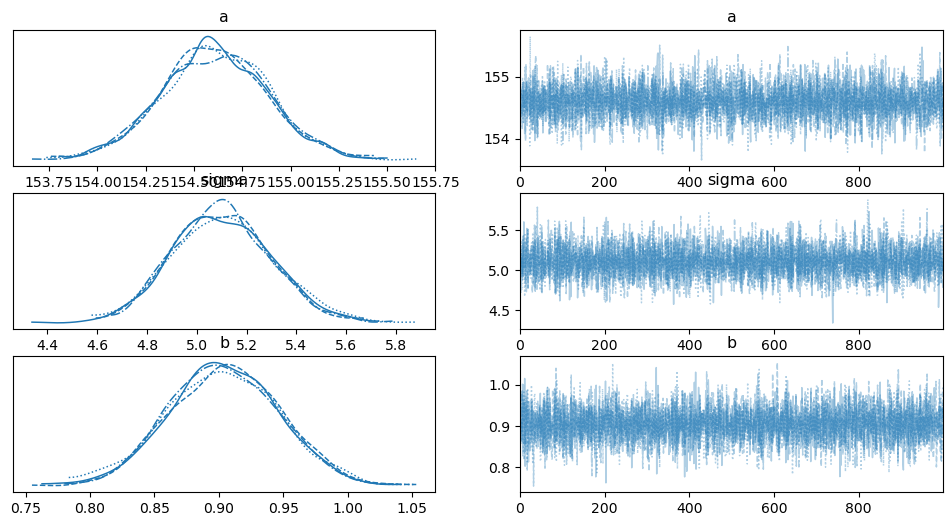

In [52]:
az.plot_trace(height_pred_idata)

¿Qué podemos decir?

- La altura promedio, al peso promedio está alrededor de 155 cm.

- Por cada 1 kg adicional, se espera que la altura sea ~0.90 cm mayor.

- El 89% de la probabilidad de la distribución posterior de $\beta$ yace entre 0.84 y 0.97, lo que indica que valores cercanos a cero y valores mayores a uno, no son compatibles con los datos y el modelo.

**Predicciones con la posterior**

La idea principal de este modelo es hacer predicciones con él. Veamos como hacerlo.

Lo primero que podríamos hacer es tomar el promedio de las muestras de $\alpha$ y $\beta$, y graficar la relación promedio:

In [49]:
height_pred_idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

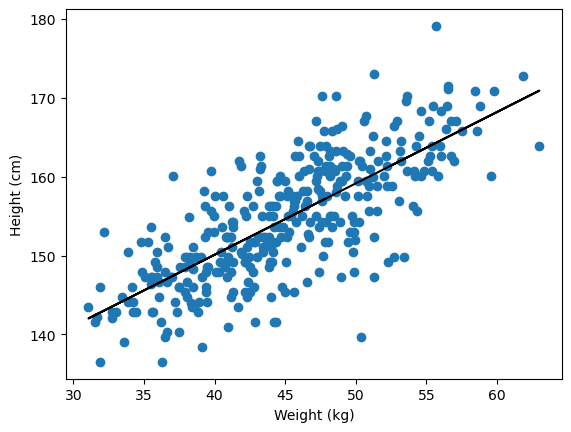

In [51]:
# Relación promedio
a_mean = height_pred_idata.posterior["a"].mean().item(0)
b_mean = height_pred_idata.posterior["b"].mean().item(0)
mu_mean = a_mean + b_mean * (weight - w_bar)
plt.scatter(
    adult_height_data["weight"], 
    adult_height_data["height"]
)
plt.plot(
    adult_height_data["weight"],
    mu_mean,
    'k'
)
plt.xlabel("Weight (kg)")
plt.ylabel("Height (cm)")
plt.show()

Esta relación promedio (al tratarse el modelo de una normal) no es más que la línea promedio; la línea más plausible en el conjunto infinito de lineas en la distribución posterior.

Sin embargo, a esto le podemos añadir la incertidumbre alrededor de la media, graficando algunas líneas muestreadas de la posterior:

In [53]:
posterior_df = height_pred_idata.posterior.to_dataframe()
posterior_df.head()

a     sigma         b
chain draw                                
0     0     154.363551  5.176075  0.875166
      1     154.854760  5.020373  0.915187
      2     154.572185  5.268166  0.927855
      3     154.787792  5.075234  0.882000
      4     154.363373  4.955088  0.895326

In [54]:
posterior_df.shape

(4000, 3)

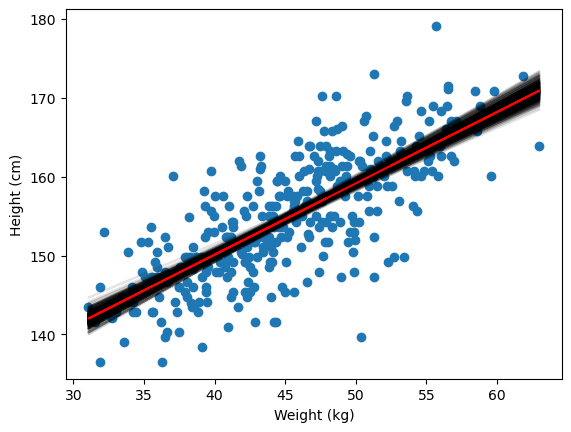

In [60]:
# Algunas muestras de la posterior
samples = np.random.randint(low=0, high=4000, size=500)
sampled_post = posterior_df.iloc[samples]
post_mu = sampled_post["a"].values + sampled_post["b"].values * (
    adult_height_data["weight"].values.reshape(-1, 1)
    - adult_height_data["weight"].mean()
)
plt.plot(
    adult_height_data["weight"],
    post_mu,
    'k',
    alpha=0.1
)
plt.plot(
    adult_height_data["weight"],
    mu_mean,
    'r'
)
plt.scatter(
    adult_height_data["weight"], 
    adult_height_data["height"]
)
plt.xlabel("Weight (kg)")
plt.ylabel("Height (cm)")
plt.show()

Una pregunta que nos podríamos hacer es, ¿Cuánto es la altura promedio de una persona de 60kg?. Una vez más, podemos usar las muestras de la posterior para responder a esta pregunta:

In [62]:
# mu at 60
mu_at_60 = sampled_post["a"].values + sampled_post["b"].values * (
    60 - adult_height_data["weight"].mean()
)
mu_at_60.shape

(500,)

In [68]:
mu_at_60.mean()

168.21186887457537

<Axes: >

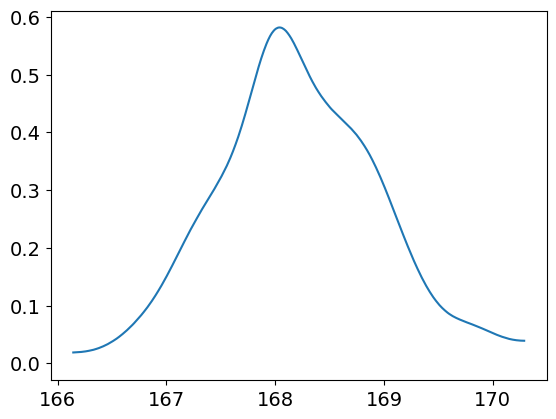

In [63]:
# kde plot
az.plot_kde(mu_at_60)

In [64]:
# az.hdi
az.hdi(mu_at_60, hdi_prob=0.89)

array([167.0220346 , 169.30913653])

La altura promedio (89%) está entre 167 cm y 169 cm (condicional al modelo y los datos), dado que el peso es 60 kg.

**¿Y $\sigma$?**

Recordemos que el modelo de la altura era:

$$
h_i \sim \text{Normal}(\mu_i, \sigma)
$$

y aunque hasta ahora solo hemos hablado de $\mu$, la variación fuera del promedio es bastante importante.

Primero, generamos las muestras de predicción. Como antes, podríamos hacerlo a mano, pero pymc lo puede hacer por nosotros:

In [65]:
# Generamos muestras predictivas de la posterior
with height_model_predictive:
    height_pred = pm.sample_posterior_predictive(height_pred_idata)

Sampling: [height]


/home/esteban/anaconda3/envs/stat-rethink2-pymc_v4/lib/python3.10/site-packages/arviz/plots/hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


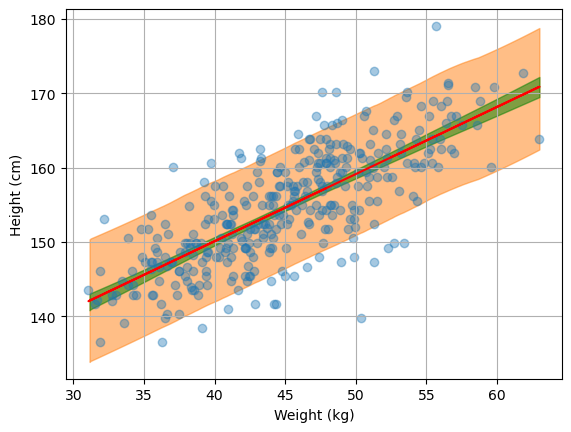

In [69]:
# Intervalo de credibilidad de la altura
az.plot_hdi(
    adult_height_data["weight"],
    height_pred.posterior_predictive["height"],
    hdi_prob=0.89
)
# Intervalo de credibilidad de la altura promedio
az.plot_hdi(
    adult_height_data["weight"],
    post_mu.T,
    hdi_prob=0.89,
    color="g"
)
# Línea promedio
plt.plot(
    adult_height_data["weight"],
    mu_mean,
    'r'
)
# Nube de puntos
plt.scatter(
    adult_height_data["weight"], 
    adult_height_data["height"],
    alpha=0.4
)
plt.grid()
plt.xlabel("Weight (kg)")
plt.ylabel("Height (cm)")
plt.show()

## 4. Comentarios finales

Como en el módulo 1, podemos usar este mismo tipo de modelos lineales en los parámetros para representar relaciones no lineales entre los datos. Podemos usar polinomios, o cualquier otro tipo de representaciones no lineales que nos interese.

Por ejemplo, si consideraramos todos los datos, incluyendo los de los niños:

Text(0, 0.5, 'Height (cm)')

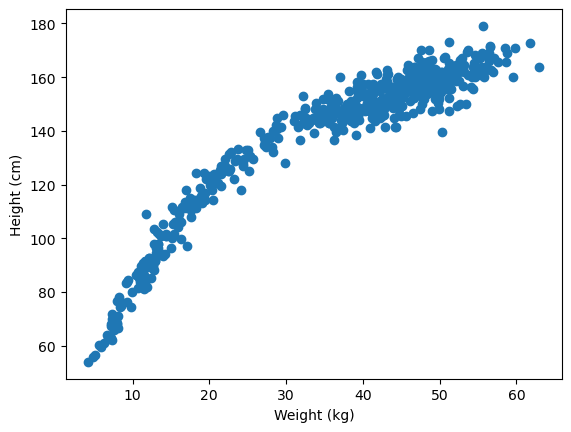

In [71]:
# Scatter plot
plt.scatter(height_data["weight"], height_data["height"])
plt.xlabel("Weight (kg)")
plt.ylabel("Height (cm)")

Observamos una relación cúbica. **Tarea**

**Ayuda**. Estandarizar el peso antes.

## Tarea adicional.

Estudiar las distribuciones:

* Uniforme
* Normal
* Beta
* Exponencial
* Lognormal
* Gamma